In [57]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Configuration
# Load data
IMG_DIR = "../../../Rock_CT_images/synthetic/images/"  # Replace with the image directory
MASK_DIR = "../../../Rock_CT_images/synthetic/masks/"    # Replace with the mask directory
IMG_SIZE = (128, 128)
BATCH_SIZE = 8
LR = 1e-3
EPOCHS = 20
TEST_SPLIT = 0.2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
# Dataset Definition
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(img_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])
        
        image = Image.open(img_path).convert("L")  # Grayscale
        mask = Image.open(mask_path).convert("L")  # Binary mask
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            mask = (mask > 0.5).float()  # Convert to binary (0,1)
        
        return image, mask

# Transforms
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

# Load Dataset
dataset = SegmentationDataset(IMG_DIR, MASK_DIR, transform)
train_size = int((1 - TEST_SPLIT) * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [59]:
# Define a Simple FCN Model
class SimpleFCN(nn.Module):
    def __init__(self):
        super(SimpleFCN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 1, 3, padding=1), nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [60]:
# Define a Smaller Model
class SmallUNet(nn.Module):
    def __init__(self):
        super(SmallUNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU()
            )
        
        self.encoder1 = conv_block(1, 32)
        self.encoder2 = conv_block(32, 64)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = conv_block(64, 128)
        
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = conv_block(128, 64)
        
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder1 = conv_block(64, 32)
        
        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        
        bottleneck = self.bottleneck(self.pool(enc2))
        
        dec2 = self.decoder2(torch.cat([self.upconv2(bottleneck), enc2], dim=1))
        dec1 = self.decoder1(torch.cat([self.upconv1(dec2), enc1], dim=1))
        
        return self.sigmoid(self.final_conv(dec1))

In [61]:
# Initialize Model, Loss, and Optimizer
model = SmallUNet().to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


In [62]:
# Count Parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {num_params}")

Total Trainable Parameters: 465953


In [63]:
# Training Loop
def train():
    model.train()
    for epoch in range(EPOCHS):
        epoch_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss/len(train_loader):.4f}")

# Run Training
train()


Epoch 1/20, Loss: 0.0871
Epoch 2/20, Loss: 0.0085
Epoch 3/20, Loss: 0.0044
Epoch 4/20, Loss: 0.0033
Epoch 5/20, Loss: 0.0028
Epoch 6/20, Loss: 0.0024
Epoch 7/20, Loss: 0.0021
Epoch 8/20, Loss: 0.0020
Epoch 9/20, Loss: 0.0018
Epoch 10/20, Loss: 0.0017
Epoch 11/20, Loss: 0.0015
Epoch 12/20, Loss: 0.0014
Epoch 13/20, Loss: 0.0013
Epoch 14/20, Loss: 0.0011
Epoch 15/20, Loss: 0.0010
Epoch 16/20, Loss: 0.0010
Epoch 17/20, Loss: 0.0009
Epoch 18/20, Loss: 0.0008
Epoch 19/20, Loss: 0.0007
Epoch 20/20, Loss: 0.0007


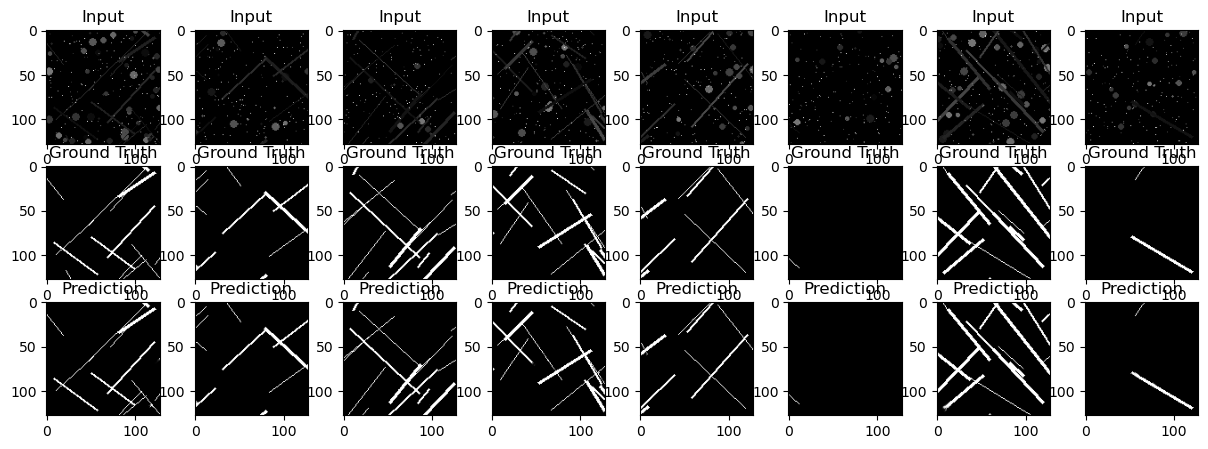

In [64]:

# Evaluation Function
def visualize_predictions():
    model.eval()
    images, masks = next(iter(test_loader))
    images, masks = images.to(DEVICE), masks.to(DEVICE)
    with torch.no_grad():
        outputs = model(images)
    
    fig, axs = plt.subplots(3, BATCH_SIZE, figsize=(15, 5))
    for i in range(BATCH_SIZE):
        axs[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
        axs[0, i].set_title("Input")
        axs[1, i].imshow(masks[i].cpu().squeeze(), cmap='gray')
        axs[1, i].set_title("Ground Truth")
        axs[2, i].imshow(outputs[i].cpu().squeeze(), cmap='gray')
        axs[2, i].set_title("Prediction")
    plt.show()

# Show results
visualize_predictions()


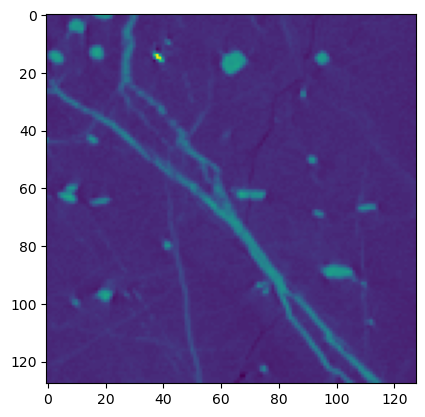

In [65]:
image = Image.open('./resized_image.png').convert("L")
plt.imshow(image)

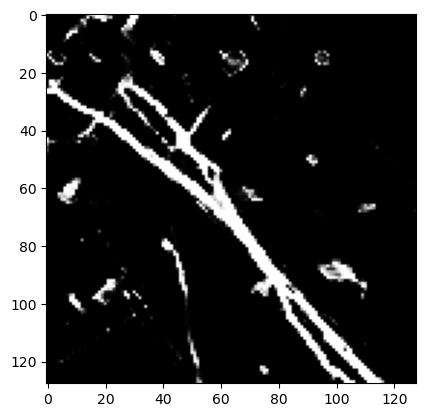

In [66]:
plt.imshow(model(torch.Tensor(np.array(image)/255.0).unsqueeze(0).unsqueeze(0).to(DEVICE)).detach().cpu().squeeze(), cmap='gray')